In [217]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [218]:
%load_ext autoreload
%autoreload 2
# GitHub cannot display the Table of Contents!

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [113]:
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']
import numpy as np

import matplotlib.pyplot as plt

# from pyha.cores.filter.moving_average.moving_average import plotter
from pyha.simulation.simulation_interface import trace_plotter

# Examples

## Noise removal

In [204]:
np.random.seed(0)
t = np.linspace(0,2*2*np.pi,512)
signal = 0.8*np.sin(t)
noise = 0.15*np.random.normal(size=512)
input_signal = signal +  noise

In [219]:
dut = MovingAverage(window_len=128)
sims = simulate(dut, input_signal, simulations=simulations, trace=True)

INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 512/512 [00:00<00:00, 13796.08it/s]

INFO:sim:Flushing the pipeline... have 510 valid samples, need 512
INFO:sim:Flushing took 2 cycles
INFO:sim:OK!
INFO:sim:Simulations completed!


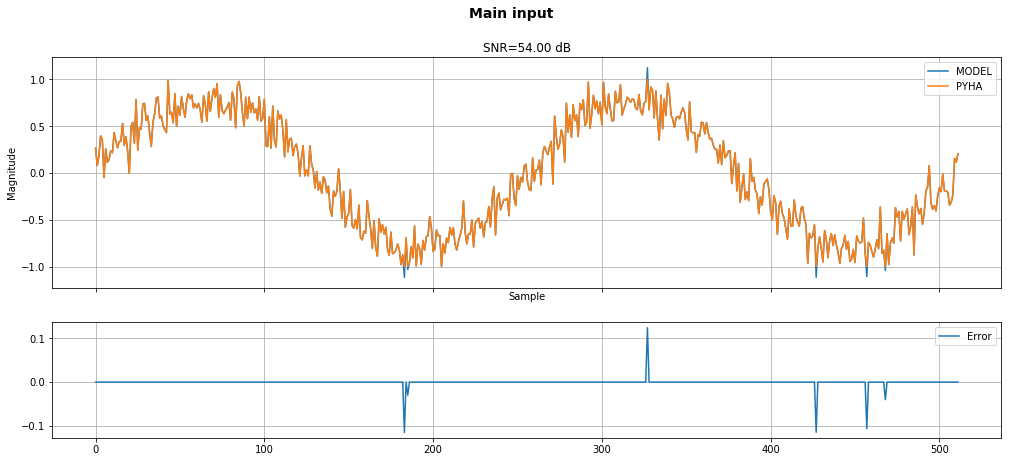

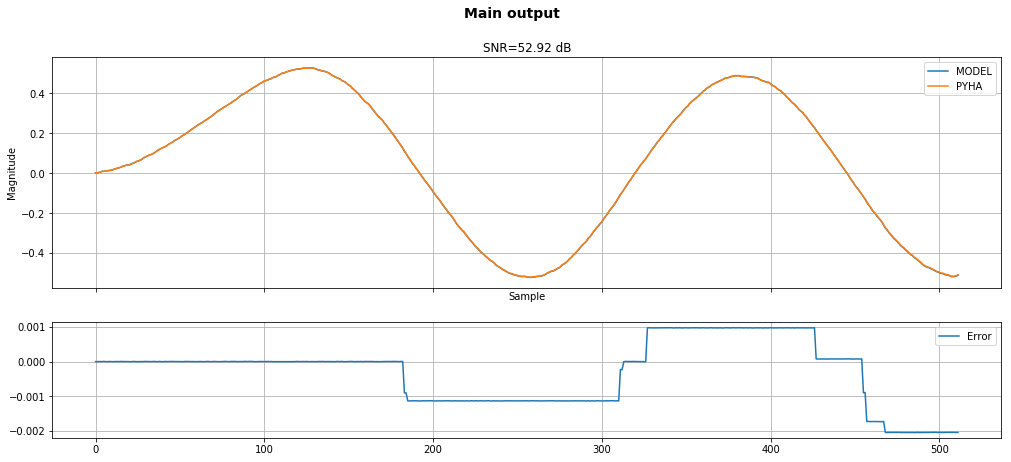

In [220]:
trace_plotter()

## Low pass filter

In [223]:
inp = [0.0] * 1024 * 4
inp[0] = 1.0
dut = MovingAverage(window_len=128)
sims = simulate(dut, inp, simulations=simulations, trace=True)

INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 4096/4096 [00:00<00:00, 13488.60it/s]

INFO:sim:Flushing the pipeline... have 4094 valid samples, need 4096
INFO:sim:Flushing took 2 cycles
INFO:sim:OK!
INFO:sim:Simulations completed!


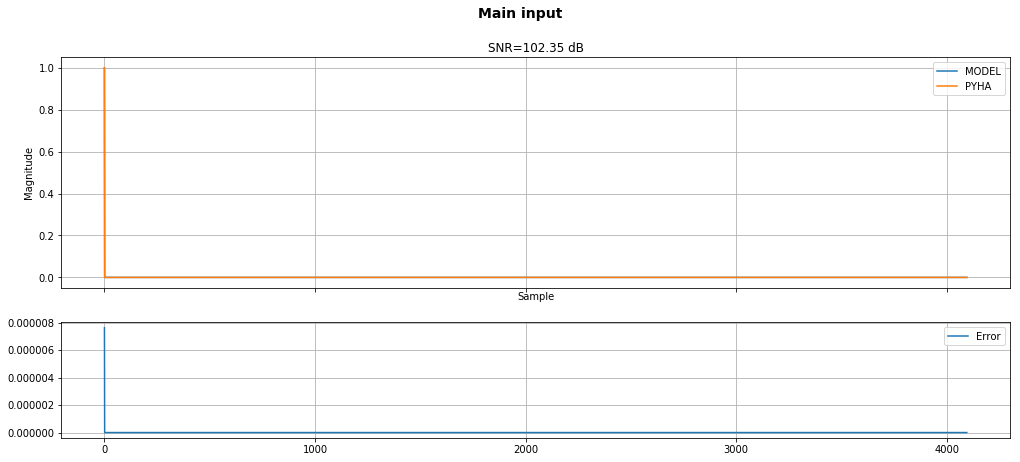

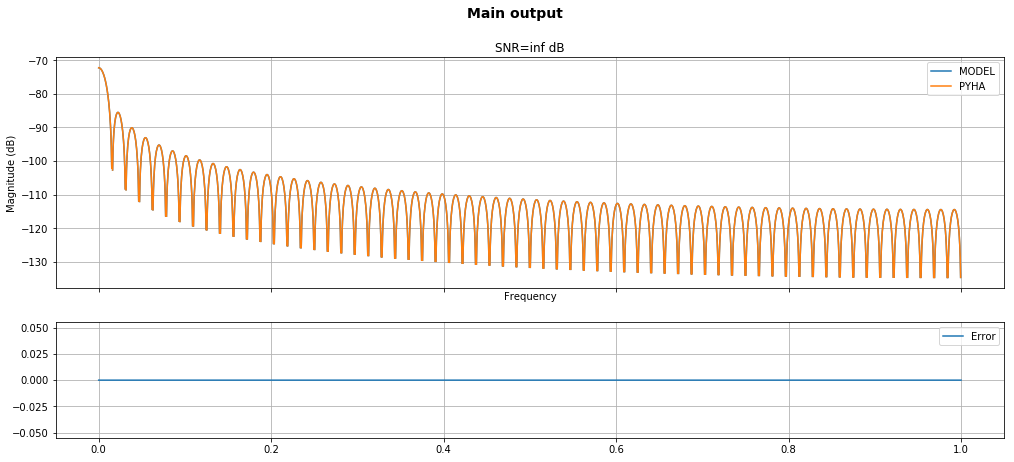

In [224]:
trace_plotter(input_domain='time', output_domain='frequency')

## Matched filter

In [207]:
bits = [1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
oversample = np.array([[x] * 32 for x in bits]).flatten()
noisy = (oversample + np.random.normal(size=len(oversample))*0.5) * 0.25

In [210]:
dut = MovingAverage(window_len=32)
sims = simulate(dut, noisy, simulations=simulations, trace=True)

INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 512/512 [00:00<00:00, 14926.45it/s]

INFO:sim:Flushing the pipeline... have 510 valid samples, need 512
INFO:sim:Flushing took 2 cycles
INFO:sim:OK!
INFO:sim:Simulations completed!


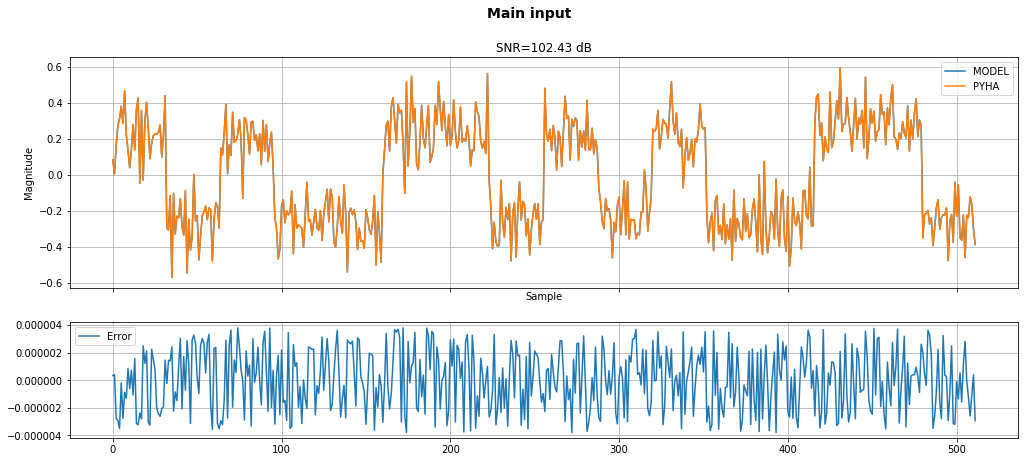

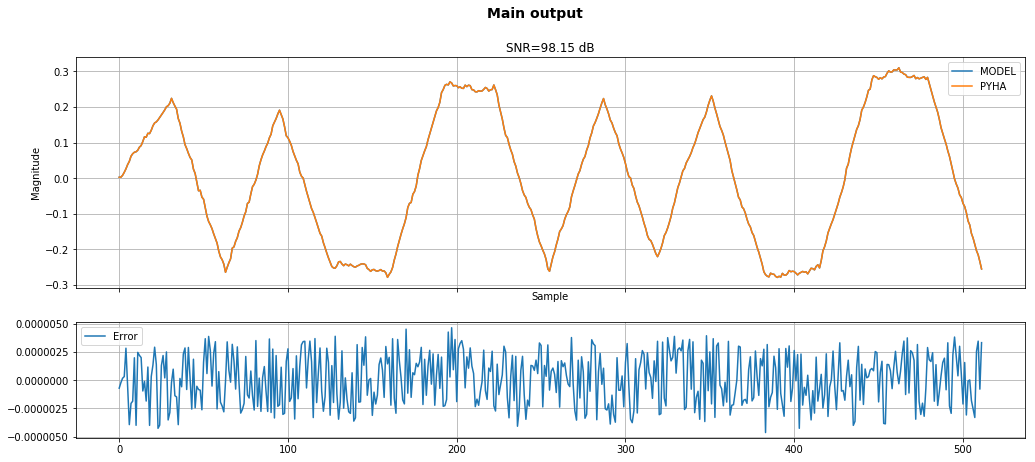

In [211]:
trace_plotter(input_domain='time', output_domain='time')

# Limitations

## 18-bit Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [ ]:
print(f'Minimum number representabe: {2**-17}')

# Synthesis

In [212]:
output_dir = '~/Documents/pyha_output'
dut = MovingAverage(window_len=128)
sims = simulate(dut, signal, simulations=['MODEL', 'PYHA', 'RTL', 'GATE'], conversion_path=output_dir)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 512/512 [00:00<00:00, 3953.74it/s]

INFO:sim:Flushing the pipeline... have 510 valid samples, need 512
INFO:sim:Flushing took 2 cycles
INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...


INFO:conversion:DownCounter to VHDL ...
INFO:conversion:MovingAverage to VHDL ...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:MovingAverage to VHDL ...
INFO:sim:Generating quartus netlist...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Simulations completed!


In [213]:
assert_simulations_equal(sims, atol=1e-5)

In [214]:
quartus = QuartusHelper(output_dir, silent=True)
quartus.fit()
print(quartus.get_resource_usage('fit'))

Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 114 / 39,600 ( < 1 % )
    Total combinational functions : 99 / 39,600 ( < 1 % )
    Dedicated logic registers : 78 / 39,600 ( < 1 % )
Total registers : 78
Total pins : 40 / 329 ( 12 % )
Total virtual pins : 0
Total memory bits : 2,250 / 1,161,216 ( < 1 % )
Embedded Multiplier 9-bit elements : 0 / 232 ( 0 % )
Total PLLs : 0 / 4 ( 0 % )



In [215]:
print(quartus.get_fmax())

+--------------------------------------------------+
; Fmax Summary                                     ;
+------------+-----------------+------------+------+
; Fmax       ; Restricted Fmax ; Clock Name ; Note ;
+------------+-----------------+------------+------+
; 199.08 MHz ; 199.08 MHz      ; clk        ;      ;
+------------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by the same clock.  Paths of different clocks, including generated clocks, are ignored.  For paths between a clock and its inversion, FMAX is computed as if the rising and falling edges are scaled along with FMAX, such that the duty cycle (in terms of a percentage) is maintained. Altera recommends that you always use clock constraints and other slack reports for sign-off analysis.

